0.01096965511460289


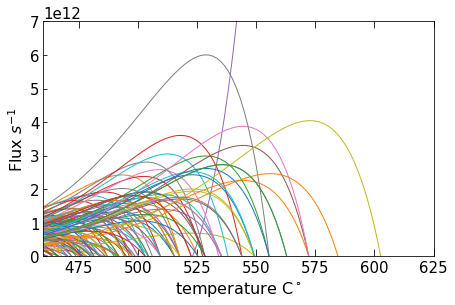

In [4]:
#********************************************************************
# Note: attempt to do everything in 10 except read more data from a file
#********************************************************************

#Global Constants
kB       = 1.38064852*10**(-23) # m^2 kg s^-2 K^-1 (boltzmann constant)
M        = 171*1.66054e-27      # mass of Yb in kg
sigma    = 1.5*10**(-19)        # cross sectional area of an atom

#Libraries
import matplotlib.pyplot as plt #plotting
import numpy as np
import matplotlib.pylab as pylab #plotting
import scipy.integrate as integrate #integrating
from numpy import sqrt, sin, cos, pi
from decimal import Decimal
import pandas as pd

#formatting plots
pylab.rcParams['figure.figsize'] = 7,7/1.62
pylab.rcParams['figure.autolayout'] = False
pylab.rcParams.update({'axes.labelsize': 20})
pylab.rcParams.update({'xtick.labelsize': 15})
pylab.rcParams.update({'ytick.labelsize': 15})
pylab.rcParams.update({'lines.linewidth': 1.0})
pylab.rcParams.update({'axes.titlesize': 20.0})

pylab.rcParams.update({'ytick.direction': 'in'}) 
pylab.rcParams.update({'xtick.major.size': 7})   
pylab.rcParams.update({'xtick.direction': 'in'}) 
pylab.rcParams.update({'xtick.top': True}) 
pylab.rcParams.update({'xtick.minor.bottom': True}) 

plt.ylabel('Flux $s^{-1}$',fontsize=16)
plt.xlabel('temperature C$^\circ$', fontsize=16)


#reading data from a file
data = pd.read_csv("C:/Users/Lab 2/Desktop/kayla//radiii.csv", header=0)

#Set Parameters
lowT = 460 
hghT = 625
steps = 100 
len_algn_fud = 3                              # alignment fudge factor
h_clamp      = 2*10**(-3)                     # height of the clamp

#Dimensional Parameters of DPT (m)
R_DPT         = 2.5*10**(-3)             # radius of DPT
L_DPT         = 518*10**(-3)             # length from the end of nozzle to the end of DPT   


# outer diameter radius and inner array parameters picked from the sheet based on small wall thickness
rOD = np.array(data['rOD'])*(0.0254/2) 
rID = np.array(data['rID'])*(0.0254/2) 
gauge = np.array(['19X','20XX','21XX','22XX','23XX','25XX','27X','33X'])          

#*****************************************************************************************
# Calculating Dimensional Parameters
#*****************************************************************************************

# length and heigh calculation of the triangle
trngle_len    = 2*np.sqrt(3)*R_DPT       # length of the triangle to match DPT
h_trngle      = trngle_len*np.sqrt(3)/2  # height of the triangle to match DPT

# Number of tubes calculations
n             = trngle_len/(2*rOD)                          # number of tubes along the side of the triangle
N_tubes       = n*(n+1)/2                                   # number of tubes, triangular numbers formula

# Area calculations
A_trngle      = (trngle_len**(2)*sqrt(3)/4)                 # area of triangle nozzle without tubes
A_open        = A_trngle - N_tubes*pi*(rOD**2 - rID**2)     # m^2, total open area of nozzle 
area_DPT      = pi*R_DPT**(2)                               # area of the DPT  

# Angle and length of tubes calculations
theta_DPT     = np.arctan(R_DPT/L_DPT)                      # maximum angle of atoms out of the DPT 
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
L_opt_fud     = L_opt/len_algn_fud                          # fudged optimal length of tubes
L_DPT_fud     = L_DPT/len_algn_fud                          # optimal length of tubes with fudge factor
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
theta_DPT_fud = np.arctan(R_DPT/L_DPT_fud)                  # maximum angle with fudged length

# Ratios - solid angle and the area ratio
r_sld_angles_fud = (theta_DPT)**2/(theta_DPT_fud)**2        # Area Ratio of theta_DPT and theta_DPT_fud
area_ratio       = area_DPT/A_trngle                        # Area Ratio

# trapezoidal calculations for the clamp dimensions
clamp_lid_len = trngle_len + 2*h_clamp/(np.sqrt(3))
side_clamp    = np.sqrt(h_clamp**(2)+ h_clamp**(2)/3)

#*****************************************************************************************
# Calculating Temperature Parameters
#*****************************************************************************************

# Convert set temperature in Celcius to Kelvin
T_oven       = np.linspace(lowT, hghT, steps)  # range of the temperature of the oven in celcius  
T = T_oven + 273

# Quantities which all Depend on temperature: pressure, density, velocity
P        = 10**(5.006 + 9.111 - 8111/T -1.0849*np.log10(T)) # pressure calculation
v_tilde  = np.sqrt(kB*T/M)                                  # convenient redefinition
n_0      = P/(kB*T)                                         # Number of atoms per Volume
v_mp     = np.sqrt(2)*v_tilde                               # most probable velocity
v_avg    = np.sqrt(8/(np.pi))*v_tilde                       # avergae velocity
v_rms    = np.sqrt(3)*v_tilde                               # root-mean-square velocity
MFP      = 1/(n_0*sigma)                                    # mean free path of the atoms

#*****************************************************************************************
# Flux Calculations
#*****************************************************************************************

# Integration
I       = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT)     # integration for the ideal numbers
I_fud   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT_fud) # integration for the fudged numbers

chk = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux = A_open[i]*v_mp[j]*n_0[j]*I[0]
        chk  = np.append(chk, Flux)

# For each radius there is now a range of temperature
# each sub array is the variation in flux due to temp, the giant array is for each radius
Flux_all = np.reshape(chk,(-1, len(T_oven)))

# NOTE: one square brace number in this 2D array represents which radius you want
# adding another is the element in 
# subarray

chk2 = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux_fud = A_open[i]*v_mp[j]*n_0[j]*I_fud[0]
        chk2  = np.append(chk2, Flux_fud)
        
Flux_fud_all = np.reshape(chk2,(-1, len(T_oven)))
Flux_DPT_fud  = Flux_fud_all*r_sld_angles_fud*area_ratio

# Fractions with collisions
chk_f = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        f = L_opt_fud[i]/MFP[j]
        chk_f = np.append(chk_f,f)
        
f_new  = np.reshape(chk_f,(-1,len(T_oven)))

# storing all the fluxes in a 2D array

# ACCESSING:  the first brace number is the radius, the second is an element of flux for that radius
temp = np.array([])
for i in range(0,len(rOD)):
    Flux_calc = Flux_DPT_fud[i] - f_new[i]*Flux_DPT_fud[i]
    temp = np.append(temp,Flux_calc)

# total flux when collisions accounted for 
Flux_tot = np.reshape(temp,(-1,len(T_oven)))

for i in range(0,len(rOD)):
    plt.plot(T_oven,Flux_tot[i], label=i+1)


# minimum and maximum values on the plot
plt.ylim(ymin=0,ymax = .7*10**(13))
plt.xlim(xmin=lowT,xmax=hghT)

#plt.legend(fontsize=12)
pylab.savefig('FluxvsTemp2.pdf', format='pdf', dpi=1000,bbox_inches='tight')
print(clamp_lid_len)